In [1]:
import pandas as pd
from numpy import unique, sum, array, zeros, inf, logspace, identity, diagonal
from numpy.linalg import inv, det, cond, eig
from numpy.random import permutation
from statistics import mean, median, stdev
import matplotlib.pyplot as plt
from math import log as ln

df = pd.read_csv('./dataset/parkinsons.csv')

# output vector
y = df['status'].values
# dictionary with all estimators
estimators = {i:{'y_hat': [], 'accuracies': [], 'best accuracy': 0, 'worst accuracy': inf} for i in ('gaussian bayesian classifier eq.12', 'gaussian bayesian classifier eq.12+PCA', 'gaussian bayesian classifier eq.44', 'gaussian bayesian classifier eq.44+PCA', 'ML with pool matrix eq.17', 'ML with pool matrix eq.17+PCA', 'ML with pool matrix eq.39', 'ML with pool matrix eq.39+PCA', 'LS classifier', 'LS classifier+PCA')}
# instances matrix -> [p attributes x N instances]
X = df.drop(['status', 'name'], axis=1).values.T

# number of classes 0 -> healthy; 1 -> Parkinson's disease (PD)
K = unique(y).size
# N -> number of instances; p -> number of attributes, OBS: x_n \in \Real^p, for 1<=n<=N
p, N = X.shape
# number of iterations
N_iter = 100
# number of instances of the train set
N_trn = N*80//100 # 80% of the instances for train and 20% for test

The covariance matrix of a vector of random variables
$$\mathbf{x} = \begin{bmatrix} x_1, x_2, \cdots, x_p \end{bmatrix}^\mathsf{T} \in \mathbb{R}^p$$
is defined as the second-order central moments of its components, that is

$\mathbf{C}_k = \begin{bmatrix}
E[(x_1 - m_1)^2]  & E[(x_1 - m_1)(x_2 - m_2)] & \cdots & E[(x_1 - m_1)(x_p - m_p)] \\
E[(x_2 - m_2)(x_1 - m_1)] & E[(x_2 - m_2)^2]  & \cdots & E[(x_2 - m_2)(x_p - m_p)] \\
\vdots    & \vdots    & \ddots & \vdots \\
E[(x_p - m_p)(x_1 - m_1)] & E[(x_p - m_p)(x_2 - m_2)] & \cdots & E[(x_p - m_p)^2]
\end{bmatrix},$

where $E[x_i]\triangleq m_k$ denotes the expected value of the random variable $x_i$ and $k\in \left\{1, 2, \cdots, K\right\}$ is the $k$-th class, $\omega_k$, in which the covariance matrix is estimated, being $K$ the total number of classes. As it is the estimation of the $k$-th class, obviously, $\mathbf{x}$ belongs to this class.

Note that the main diagonal of $\mathbf{C}_k$ is the variance of $x_i$, hereafter denoted as $\sigma_k^2$. The elements outside of the main diagonal are the covariance, which can be written as
$$E[(x_i - m_i)(x_l - m_l)] \triangleq \sigma_{il} = \sigma_{i}\sigma_{l}\rho_{il}$$

where the last equation comes from the correlation coefficient ($\rho_{il}$) definition.

Hence, the covariance matrix can be rewritten as

$\mathbf{C}_k = \begin{bmatrix}
\sigma_1^2  & \sigma_{1}\sigma_{2}\rho_{12} & \cdots & \sigma_{1}\sigma_{p}\rho_{1p} \\
\sigma_{2}\sigma_{1}\rho_{21} & \sigma_2^2  & \cdots & \sigma_{2}\sigma_{p}\rho_{2p} \\
\cdot    & \cdot    & \ddots & \vdots \\
\sigma_{p}\sigma_{1}\rho_{p1} & \sigma_{p}\sigma_{2}\rho_{p2} & \cdots & \sigma_p^2
\end{bmatrix},$

Using the matrix notation, $\mathbf{C}_k$ can be written as
\begin{align}
\mathbf{C}_k & = E\left[(\mathbf{x} - \mathbf{m}_k)(\mathbf{x} - \mathbf{m}_k)^\mathsf{T}\right] \\
& = E\left[\mathbf{x}\mathbf{x}^\mathsf{T} - \mathbf{x}\mathbf{m}_k^\mathsf{T} - \mathbf{m}_k\mathbf{x}^\mathsf{T} + \mathbf{m}_k\mathbf{m}_k^\mathsf{T}\right] \\
& = E\left[\mathbf{x}\mathbf{x}^\mathsf{T}\right] - E\left[\mathbf{x}\right]\mathbf{m}_k^\mathsf{T} - \mathbf{m}_k E\left[\mathbf{x}\right]^\mathsf{T} + \mathbf{m}_k\mathbf{m}_k^\mathsf{T} \\
& = \mathbf{R}_k - \mathbf{m}_k\mathbf{m}_k^\mathsf{T},
\end{align}

where
$\mathbf{R}_k = \begin{bmatrix}
E[x_1^2]  & E[x_1x_2] & \cdots & E[x_1x_p] \\
E[x_2x_1] & E[x_2^2]  & \cdots & E[x_2x_p] \\
\vdots    & \vdots    & \ddots & \vdots \\
E[x_px_1] & E[x_px_2] & \cdots & E[x_p^2]
\end{bmatrix} = E[\mathbf{x}\mathbf{x}^\mathsf{T}],$
and
$\mathbf{m}_k = \begin{bmatrix}
m_1  & m_2 & \cdots & m_p
\end{bmatrix},$
are the correlation matrix and the mean vector of $\mathbf{x}$, respectively.

Using a set of $N_k$ realizations $\left\{\mathbf{x}_{1}, \mathbf{x}_{2}, \cdots, \mathbf{x}_{N_k}\right\}$, where all vectors belong to $\omega_k$, the estimator of $\mathbf{R}_k$ can be calculated as
\begin{align}
\mathbf{\hat{R}}_k = \frac{1}{N_k} \sum_{n=1}^{N_k} \mathbf{x}_{n}\mathbf{x}_n
\end{align}

The estimation of the autocorrelation matrix can be computed faster using a matrix notation of all realization of the vector $\mathbf{x}$:

\begin{align}
\mathbf{X}_k = \left\{\mathbf{x}_{1}\mid \mathbf{x}_{2}\mid \cdots\mid \mathbf{x}_{N_k} \right\}
\end{align}
The estimation of the correlation matrix is simply given by
\begin{align}
\mathbf{\hat{R}}_k = \frac{1}{N_k}\mathbf{X}_k\mathbf{X}_k^\mathsf{T}
\end{align}

and the estimation of the mean vector is given by
$$\mathbf{\hat{m}}_k = \frac{1}{N_k} \sum_{n=1}^{N_k} \mathbf{x}_{n}$$

Of any input vector

For a given input vector $\mathbf{x}_{n}$ that can belong to any class, one can compute the square of the Mahalanobis distance between that new instance for the $k$-th class, $\omega_k$.

\begin{align}
    Q_k \left( \mathbf{x}_{n} \right) = \left(\mathbf{x}_{n} - \hat{\mathbf{m}}_k\right)^\mathsf{T} \hat{\mathbf{C}}_k^{-1} \left(\mathbf{x}_{n} - \hat{\mathbf{m}}_k\right)
\end{align} 

In [2]:
for _ in range(N_iter):
    # randomize train/test instances
    trn_tst = permutation(N)
    # generate train and test dataset
    X_trn, y_trn = X[:, trn_tst[:N_trn]], y[array(trn_tst[:N_trn])]
    X_tst, y_tst = X[:, trn_tst[N_trn:]], y[array(trn_tst[N_trn:])]

    ### training phase
    # p_k -> relative frequency (estimator) of P(wk)
    p_0, p_1 = (y_trn[y_trn==k].size / N_trn for k in range(K))
    # X_k -> instances that belongs to class wk
    X_0, X_1 = (X_trn[:,y_trn==k] for k in range(K))
    # N_k -> number of instances that belong to class wk
    N_0, N_1 = X_0.shape[1], X_1.shape[1]
    # m_k -> mean vector of the class wk
    m_0, m_1 = sum(X_0, axis=1, keepdims=True)/N_0, sum(X_1, axis=1, keepdims=True)/N_1
    # R_k -> correlation matrix of the class wk
    R_0 = X_0 @ X_0.T / N_0
    R_1 = X_1 @ X_1.T / N_1
    # C_k -> covariance matrix of the class wk
    C_0 = R_0 - m_0@m_0.T
    C_1 = R_1 - m_1@m_1.T
    # pool matrix - eq.19
    C = p_0*C_0 + p_1*C_1

    # LS classifier -> W
    # Tikhonov regularization
    for lambda_ in logspace(0,10,base=2):
        W = y_trn @ X_trn.T @ inv(X_trn @ X_trn.T + (lambda_-1)*identity(X_trn.shape[0]))
        # if W is ill-conditioned, regularize it
        if cond(X_trn @ X_trn.T + (lambda_-1)*identity(X.shape[0])) <= 5e3:
            break

    ### Apply PCA (Principal Components Analysis) - see Reconhecimento de Padrões's slides PCA - eq.10 to 17
    (Lambdas_0, V_0), (_, V_1) = eig(C_0), eig(C_1)
    # definition linear transformation that must be applied on the input vectors, X_0 - see eq.20 in slides
    Q_0, Q_1 = V_0.T, V_1.T
    # application of the linear transformation - see eq.22 in slides
    Z_0, Z_1 = Q_0@X_0/X_0, Q_1@X_1/X_1
    # mz_k -> mean vectors V of the class wk
    mz_0, mz_1 = sum(Z_0, axis=1, keepdims=True)/N_0, sum(Z_1, axis=1, keepdims=True)/N_1
    # R_k -> correlation matrix of vector V that belongs to the class wk
    Rz_0 = Z_0 @ Z_0.T / N_0
    Rz_1 = Z_1 @ Z_1.T / N_1
    # Cz_k -> covariance matrix of vector V that belongs to the class wk
    Cz_0 = Rz_0 - mz_0@mz_0.T
    Cz_1 = Rz_1 - mz_1@mz_1.T
    # pool matrix - eq.19
    Cz = p_0*Cz_0 + p_1*Cz_1


    # LS classifier with PCA -> W
    # m_trn -> mean vector of the train dataset
    m_trn = sum(X_trn, axis=1, keepdims=True)/N_trn
    # R_trn -> correlation matrix of the train dataset
    R_trn = X_trn @ X_trn.T / N_trn
    # C_trn -> covariance matrix of the train dataset
    C_trn = R_trn - m_trn@m_trn.T
    # V_trn -> eigenvectors of the covariance matrix of the train dataset
    _, V_trn = eig(C_trn)
    # Q_trn -> linear transformation that must be applied on the input vectors, X_trn
    Q_trn = V_trn.T
    # new input dataset that shall be used in the LS classifier+PCA
    Z_trn = Q_trn@X_trn

    # Tikhonov regularization
    for lambda_ in logspace(0,10,base=2):
        Wz = y_trn @ Z_trn.T @ inv(Z_trn @ Z_trn.T + (lambda_-1)*identity(Z_trn.shape[0]))
        # if W is ill-conditioned, regularize it
        if cond(Z_trn @ Z_trn.T + (lambda_-1)*identity(X.shape[0])) <= 5e3:
            break
    

    # a proof that, indeed C_0@V_0 == Lambdas_0*V_0
    if 'PCA_proof' not in locals():
        PCA_proof = C_0@V_0, Lambdas_0*V_0

    ### test phase
    # appending a new counter to the next test phase
    for estimator in estimators.keys():
        estimators[estimator]['accuracies'].append(0)
    for x, y_n in zip(X_tst.T, y_tst): # for each instance (each column)
        x = x[:,None] # make it a px1 vector
        z = Q_trn@x
        confusion_matrices = {i: zeros((K, K)) for i in estimators.keys()}

        ### gaussian bayesian classifier -> eq.12
        # Q_k Mahalanobis distance of x from the class w_k
        for C_, estimator_name, xz, mxz in zip(((C_0, C_1), (Cz_0, Cz_1)), ('gaussian bayesian classifier eq.12', 'gaussian bayesian classifier eq.12+PCA'), (x, z), ((m_0, m_1), (mz_0, mz_1))):
            Q_0 = (xz - mxz[0]).T @ inv(C_[0]) @ (xz - mxz[0])
            Q_1 = (xz - mxz[1]).T @ inv(C_[1]) @ (xz - mxz[1])
            
            g_0 = -.5*Q_0 - .5*ln(det(C_[0])) + ln(p_0)
            g_1 = -.5*Q_1 - .5*ln(det(C_[1])) + ln(p_1)
            # decision criteria eq.7
            estimators[estimator_name]['y_hat'].append(0) if g_0 > g_1 else estimators[estimator_name]['y_hat'].append(1)

        ### gaussian bayesian classifier -> eq.44
        for C_, estimator_name, xz, mxz in zip(((C_0, C_1), (Cz_0, Cz_1)), ('gaussian bayesian classifier eq.44', 'gaussian bayesian classifier eq.44+PCA'), (x, z), ((m_0, m_1), (mz_0, mz_1))):
            g_0 = -.5*xz.T@inv(C_[0])@xz + mxz[0].T@inv(C_[0])@xz - .5*mxz[0].T@inv(C_[0])@mxz[0] - .5*ln(det(C_[0]))
            g_1 = -.5*xz.T@inv(C_[1])@xz + mxz[1].T@inv(C_[1])@xz - .5*mxz[1].T@inv(C_[1])@mxz[1] - .5*ln(det(C_[1]))
            # decision criteria eq.7
            estimators[estimator_name]['y_hat'].append(0) if g_0 > g_1 else estimators[estimator_name]['y_hat'].append(1)


        ### ML with pool matrix -> eq.17
        for C_, estimator_name, xz, mxz in zip((C, Cz), ('ML with pool matrix eq.17', 'ML with pool matrix eq.17+PCA'), (x, z), ((m_0, m_1), (mz_0, mz_1))):
            # Q_k Mahalanobis distance of x from the class w_k (with pool matrix) 
            Q_0 = (xz - mxz[0]).T @ inv(C_) @ (xz - mxz[0])
            Q_1 = (xz - mxz[1]).T @ inv(C_) @ (xz - mxz[1])
            # decision criteria eq.18
            estimators[estimator_name]['y_hat'].append(0) if Q_0 < Q_1 else estimators[estimator_name]['y_hat'].append(1)

        ### ML with pool matrix -> eq.39
        for C_, estimator_name, xz, mxz in zip((C, Cz), ('ML with pool matrix eq.39', 'ML with pool matrix eq.39+PCA'), (x, z), ((m_0, m_1), (mz_0, mz_1))):
            g_0 = mxz[0].T@inv(C_)@xz - .5*mxz[0].T@inv(C_)@mxz[0]
            g_1 = mxz[1].T@inv(C_)@xz - .5*mxz[1].T@inv(C_)@m_1
            # decision criteria eq.7
            estimators[estimator_name]['y_hat'].append(0) if g_0 > g_1 else estimators[estimator_name]['y_hat'].append(1)


        ### LS classifier
        for W_, estimator_name, xz in zip((W, Wz), ('LS classifier', 'LS classifier+PCA'), (x, z)):
            estimators[estimator_name]['y_hat'].append(0) if W_@xz < .5 else estimators[estimator_name]['y_hat'].append(1)
        

        # update the accuracy
        for estimator in estimators.keys():
            y_hat = estimators[estimator]['y_hat'][-1]
            if y_hat  == y_n:
               estimators[estimator]['accuracies'][-1] += 1/y_tst.size
            # update confusion matrix
            confusion_matrices[estimator][y_hat][y_n] += 1
    # update the best and worst confusion matrix
    for estimator in estimators.keys():
        if estimators[estimator]['accuracies'][-1] > estimators[estimator]['best accuracy']:
            estimators[estimator]['best accuracy'] = estimators[estimator]['accuracies'][-1]
        elif estimators[estimator]['accuracies'][-1] < estimators[estimator]['worst accuracy']:
            estimators[estimator]['worst accuracy'] = estimators[estimator]['accuracies'][-1]

# Statistics

In [3]:
for estimator in estimators.keys():
    estimators[estimator]['mean'] = mean(estimators[estimator]['accuracies'])
    estimators[estimator]['median'] = median(estimators[estimator]['accuracies'])
    estimators[estimator]['sd'] = stdev(estimators[estimator]['accuracies'])
    estimators[estimator]['min'] = min(estimators[estimator]['accuracies'])
    estimators[estimator]['max'] = max(estimators[estimator]['accuracies'])

# Table

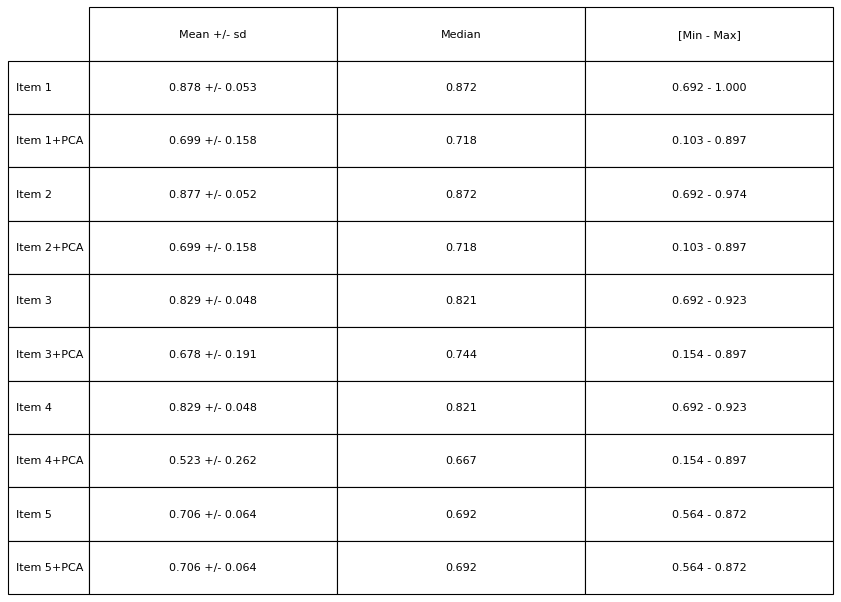

In [4]:
fig = plt.figure(figsize=(12, 3), dpi=80)
ax = fig.gca()
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
col_labels = ['Mean +/- sd', 'Median', '[Min - Max]']
row_labels = [f'Item {i}{j}' for i in range(1,6) for j in ('', '+PCA')]
cell_tex = [(f"{x['mean']:.3f} +/- {x['sd']:.3f}", f"{x['median']:.3f}", f"{x['min']:.3f} - {x['max']:.3f}") for x in estimators.values()]

table_ = ax.table(cellText=cell_tex, colLabels=col_labels, loc='center', cellLoc='center', rowLabels=row_labels)
table_.scale(1, 4)
plt.show()